## Import Libraries

In [110]:
import pandas as pd
from pandas_profiling import ProfileReport

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings #Ignore all warnings
warnings.filterwarnings("ignore")

import itertools

from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, OneHotEncoder, PolynomialFeatures 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, LassoCV, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_regression, mutual_info_regression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Import & Join Datasets

In [2]:
clinical_data = pd.read_csv('Coding_Assignment_Files/clinical_data.csv')
demo_data = pd.read_csv('Coding_Assignment_Files/demographics.csv')
billid_data = pd.read_csv('Coding_Assignment_Files/bill_id.csv')
billamt_data = pd.read_csv('Coding_Assignment_Files/bill_amount.csv')

In [3]:
# Check Shape
print(clinical_data.shape)
print(demo_data.shape)
print(billid_data.shape)
print(billamt_data.shape)

(3400, 26)
(3000, 5)
(13600, 3)
(13600, 2)


In [4]:
# Join bill_id to bill amount by bill_id - new table name 'Bills'
# Join Bills to clinical_data by id/patient_id- new table name 'Patient Bills'
# Join Patient Bills to demographic by patient_id - new table name 'treatment_df'


In [5]:
bills_df = billid_data.merge(billamt_data, on='bill_id', how='left')
bills_df.head()

bill_id                        patient_id date_of_admission  \
0  7968360812  1d21f2be18683991eb93d182d6b2d220        2011-01-01   
1  6180579974  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01   
2  7512568183  1d21f2be18683991eb93d182d6b2d220        2011-01-01   
3  3762633379  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01   
4  7654730355  1d21f2be18683991eb93d182d6b2d220        2011-01-01   

         amount  
0    951.214467  
1  19900.297086  
2  12338.269972  
3   1145.372193  
4   1133.601902

In [6]:
# Change 'id' to 'patient_id'
clinical_data = clinical_data.rename(columns = {"id":'patient_id'})
clinical_data.head()

patient_id date_of_admission date_of_discharge  \
0  1d21f2be18683991eb93d182d6b2d220        2011-01-01        2011-01-11   
1  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01        2011-01-11   
2  c85cf97bc6307ded0dd4fef8bad2fa09        2011-01-02        2011-01-13   
3  e0397dd72caf4552c5babebd3d61736c        2011-01-02        2011-01-14   
4  94ade3cd5f66f4584902554dff170a29        2011-01-08        2011-01-16   

   medical_history_1  medical_history_2 medical_history_3  medical_history_4  \
0                  0                1.0                 0                  0   
1                  0                0.0                 0                  0   
2                  0                0.0                 0                  0   
3                  0                1.0                No                  0   
4                  0                0.0                No                  0   

   medical_history_5  medical_history_6  medical_history_7  ...  symptom_1  \
0                0.0                  0                  0  ...          0   
1                0.0                  0                  0  ...          0   
2                0.0                  0                  0  ...          1   
3                0.0                  1                  1  ...          1   
4                0.0                  1                  1  ...          0   

   symptom_2  symptom_3  symptom_4  symptom_5  lab_result_1  lab_result_2  \
0          0          0          1          1          13.2          30.9   
1          0          1          1          1          13.8          22.6   
2          1          1          1          0          11.2          26.2   
3          1          1          1          1          13.3          28.4   
4          1          0          1          0          12.0          27.8   

   lab_result_3  weight  height  
0         123.0    71.3   161.0  
1          89.0    78.4   160.0  
2         100.0    72.0   151.0  
3          76.0    64.4   152.0  
4          87.0    55.6   160.0  

[5 rows x 26 columns]

In [7]:
patients_df = demo_data.merge(clinical_data, on='patient_id', how='left')
patients_df.head()

patient_id  gender     race    resident_status  \
0  fa2d818b2261e44e30628ad1ac9cc72c  Female   Indian        Singaporean   
1  5b6477c5de78d0b138e3b0c18e21d0ae       f  Chinese  Singapore citizen   
2  320aa16c61937447fd6631bf635e7fde    Male  Chinese  Singapore citizen   
3  320aa16c61937447fd6631bf635e7fde    Male  Chinese  Singapore citizen   
4  c7f3881684045e6c49020481020fae36    Male    Malay  Singapore citizen   

  date_of_birth date_of_admission date_of_discharge  medical_history_1  \
0    1971-05-14        2014-09-20        2014-10-04                  0   
1    1976-02-18        2014-08-08        2014-08-18                  0   
2    1982-07-03        2011-03-10        2011-03-20                  0   
3    1982-07-03        2013-07-02        2013-07-14                  0   
4    1947-06-15        2015-10-28        2015-11-10                  0   

   medical_history_2 medical_history_3  ...  symptom_1  symptom_2  symptom_3  \
0                0.0                 0  ...          1          1          0   
1                0.0                No  ...          1          1          1   
2                0.0                No  ...          0          0          1   
3                0.0                 0  ...          1          0          0   
4                1.0                 0  ...          1          1          1   

   symptom_4  symptom_5  lab_result_1  lab_result_2  lab_result_3  weight  \
0          0          1          14.2          27.0          81.0    68.1   
1          1          1          14.3          27.2          92.0    76.5   
2          1          1          14.4          26.6          92.0    69.7   
3          1          0          18.0          26.6          92.0    66.7   
4          1          1          14.9          26.7          97.0    96.9   

   height  
0   161.0  
1   151.0  
2   175.0  
3   175.0  
4   180.0  

[5 rows x 30 columns]

In [8]:
# Join on patient_id and date of admission
treatment_df = bills_df.merge(patients_df, on=['patient_id', 'date_of_admission',], how='left')
treatment_df.head()

bill_id                        patient_id date_of_admission  \
0  7968360812  1d21f2be18683991eb93d182d6b2d220        2011-01-01   
1  6180579974  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01   
2  7512568183  1d21f2be18683991eb93d182d6b2d220        2011-01-01   
3  3762633379  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01   
4  7654730355  1d21f2be18683991eb93d182d6b2d220        2011-01-01   

         amount  gender    race resident_status date_of_birth  \
0    951.214467    Male  Indian     Singaporean    1976-12-19   
1  19900.297086  Female   Malay     Singaporean    1978-07-20   
2  12338.269972    Male  Indian     Singaporean    1976-12-19   
3   1145.372193  Female   Malay     Singaporean    1978-07-20   
4   1133.601902    Male  Indian     Singaporean    1976-12-19   

  date_of_discharge  medical_history_1  ...  symptom_1 symptom_2  symptom_3  \
0        2011-01-11                  0  ...          0         0          0   
1        2011-01-11                  0  ...          0         0          1   
2        2011-01-11                  0  ...          0         0          0   
3        2011-01-11                  0  ...          0         0          1   
4        2011-01-11                  0  ...          0         0          0   

   symptom_4  symptom_5  lab_result_1  lab_result_2  lab_result_3  weight  \
0          1          1          13.2          30.9         123.0    71.3   
1          1          1          13.8          22.6          89.0    78.4   
2          1          1          13.2          30.9         123.0    71.3   
3          1          1          13.8          22.6          89.0    78.4   
4          1          1          13.2          30.9         123.0    71.3   

   height  
0   161.0  
1   160.0  
2   161.0  
3   160.0  
4   161.0  

[5 rows x 32 columns]

In [9]:
treatment_df = treatment_df.groupby(['bill_id', 'patient_id','amount'], as_index=False).apply(lambda x : x.sum())
treatment_df.head()

bill_id  \
bill_id patient_id                       amount                 
558412  54c00a685cd49f4ed59a389657af655b 6539.159300   558412   
1219378 a135b44a73f9e99424a91edc846185de 876.424366   1219378   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933   3568195   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493   3722123   
4477075 a54070aa18ab3579495a157364f70a39 397.293041   4477075   

                                                                            patient_id  \
bill_id patient_id                       amount                                          
558412  54c00a685cd49f4ed59a389657af655b 6539.159300  54c00a685cd49f4ed59a389657af655b   
1219378 a135b44a73f9e99424a91edc846185de 876.424366   a135b44a73f9e99424a91edc846185de   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933   4a8da205ade786dd74c316c39dcbe99f   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493   277ad90d43a1289b0bf22f9795c5c706   
4477075 a54070aa18ab3579495a157364f70a39 397.293041   a54070aa18ab3579495a157364f70a39   

                                                     date_of_admission  \
bill_id patient_id                       amount                          
558412  54c00a685cd49f4ed59a389657af655b 6539.159300        2013-02-23   
1219378 a135b44a73f9e99424a91edc846185de 876.424366         2013-11-28   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933         2014-12-12   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493         2012-02-16   
4477075 a54070aa18ab3579495a157364f70a39 397.293041         2012-12-03   

                                                           amount  gender  \
bill_id patient_id                       amount                             
558412  54c00a685cd49f4ed59a389657af655b 6539.159300  6539.159300  Female   
1219378 a135b44a73f9e99424a91edc846185de 876.424366    876.424366    Male   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933    956.968933    Male   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493    836.612493  Female   
4477075 a54070aa18ab3579495a157364f70a39 397.293041    397.293041    Male   

                                                         race  \
bill_id patient_id                       amount                 
558412  54c00a685cd49f4ed59a389657af655b 6539.159300  Chinese   
1219378 a135b44a73f9e99424a91edc846185de 876.424366   Chinese   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933   Chinese   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493   chinese   
4477075 a54070aa18ab3579495a157364f70a39 397.293041   Chinese   

                                                        resident_status  \
bill_id patient_id                       amount                           
558412  54c00a685cd49f4ed59a389657af655b 6539.159300        Singaporean   
1219378 a135b44a73f9e99424a91edc846185de 876.424366   Singapore citizen   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933         Singaporean   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493         Singaporean   
4477075 a54070aa18ab3579495a157364f70a39 397.293041         Singaporean   

                                                     date_of_birth  \
bill_id patient_id                       amount                      
558412  54c00a685cd49f4ed59a389657af655b 6539.159300    1974-05-09   
1219378 a135b44a73f9e99424a91edc846185de 876.424366     1946-02-09   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933     1969-11-13   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493     1973-04-21   
4477075 a54070aa18ab3579495a157364f70a39 397.293041     1968-09-05   

                                                     date_of_discharge  \
bill_id patient_id                       amount                          
558412  54c00a685cd49f4ed59a389657af655b 6539.159300        2013-03-04   
1219378 a135b44a73f9e99424a91edc846185de 876.424366         2013-12-11   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933         2014-12-25   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493         2012-

In [10]:
treatment_df = treatment_df.rename_axis(index={'bill_id':'a', 'patient_id':'b', 'amount':'c'})
treatment_df.head()

bill_id  \
a       b                                c                      
558412  54c00a685cd49f4ed59a389657af655b 6539.159300   558412   
1219378 a135b44a73f9e99424a91edc846185de 876.424366   1219378   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933   3568195   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493   3722123   
4477075 a54070aa18ab3579495a157364f70a39 397.293041   4477075   

                                                                            patient_id  \
a       b                                c                                               
558412  54c00a685cd49f4ed59a389657af655b 6539.159300  54c00a685cd49f4ed59a389657af655b   
1219378 a135b44a73f9e99424a91edc846185de 876.424366   a135b44a73f9e99424a91edc846185de   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933   4a8da205ade786dd74c316c39dcbe99f   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493   277ad90d43a1289b0bf22f9795c5c706   
4477075 a54070aa18ab3579495a157364f70a39 397.293041   a54070aa18ab3579495a157364f70a39   

                                                     date_of_admission  \
a       b                                c                               
558412  54c00a685cd49f4ed59a389657af655b 6539.159300        2013-02-23   
1219378 a135b44a73f9e99424a91edc846185de 876.424366         2013-11-28   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933         2014-12-12   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493         2012-02-16   
4477075 a54070aa18ab3579495a157364f70a39 397.293041         2012-12-03   

                                                           amount  gender  \
a       b                                c                                  
558412  54c00a685cd49f4ed59a389657af655b 6539.159300  6539.159300  Female   
1219378 a135b44a73f9e99424a91edc846185de 876.424366    876.424366    Male   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933    956.968933    Male   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493    836.612493  Female   
4477075 a54070aa18ab3579495a157364f70a39 397.293041    397.293041    Male   

                                                         race  \
a       b                                c                      
558412  54c00a685cd49f4ed59a389657af655b 6539.159300  Chinese   
1219378 a135b44a73f9e99424a91edc846185de 876.424366   Chinese   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933   Chinese   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493   chinese   
4477075 a54070aa18ab3579495a157364f70a39 397.293041   Chinese   

                                                        resident_status  \
a       b                                c                                
558412  54c00a685cd49f4ed59a389657af655b 6539.159300        Singaporean   
1219378 a135b44a73f9e99424a91edc846185de 876.424366   Singapore citizen   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933         Singaporean   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493         Singaporean   
4477075 a54070aa18ab3579495a157364f70a39 397.293041         Singaporean   

                                                     date_of_birth  \
a       b                                c                           
558412  54c00a685cd49f4ed59a389657af655b 6539.159300    1974-05-09   
1219378 a135b44a73f9e99424a91edc846185de 876.424366     1946-02-09   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933     1969-11-13   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493     1973-04-21   
4477075 a54070aa18ab3579495a157364f70a39 397.293041     1968-09-05   

                                                     date_of_discharge  \
a       b                                c                               
558412  54c00a685cd49f4ed59a389657af655b 6539.159300        2013-03-04   
1219378 a135b44a73f9e99424a91edc846185de 876.424366         2013-12-11   
3568195 4a8da205ade786dd74c316c39dcbe99f 956.968933         2014-12-25   
3722123 277ad90d43a1289b0bf22f9795c5c706 836.612493         2012-

In [11]:
treatment_df = treatment_df.droplevel([0,1]).reset_index()
treatment_df.head()

c  bill_id                        patient_id date_of_admission  \
0  6539.159300   558412  54c00a685cd49f4ed59a389657af655b        2013-02-23   
1   876.424366  1219378  a135b44a73f9e99424a91edc846185de        2013-11-28   
2   956.968933  3568195  4a8da205ade786dd74c316c39dcbe99f        2014-12-12   
3   836.612493  3722123  277ad90d43a1289b0bf22f9795c5c706        2012-02-16   
4   397.293041  4477075  a54070aa18ab3579495a157364f70a39        2012-12-03   

        amount  gender     race    resident_status date_of_birth  \
0  6539.159300  Female  Chinese        Singaporean    1974-05-09   
1   876.424366    Male  Chinese  Singapore citizen    1946-02-09   
2   956.968933    Male  Chinese        Singaporean    1969-11-13   
3   836.612493  Female  chinese        Singaporean    1973-04-21   
4   397.293041    Male  Chinese        Singaporean    1968-09-05   

  date_of_discharge  ...  symptom_1  symptom_2 symptom_3  symptom_4  \
0        2013-03-04  ...          0          1         0          1   
1        2013-12-11  ...          0          0         0          1   
2        2014-12-25  ...          0          1         1          1   
3        2012-02-27  ...          1          0         0          1   
4        2012-12-14  ...          1          1         1          1   

   symptom_5  lab_result_1  lab_result_2  lab_result_3  weight  height  
0          0          14.3          26.4         113.0    81.0   161.0  
1          1          16.0          25.9          91.0    89.9   163.0  
2          1          11.9          29.9          85.0    77.8   176.0  
3          1          11.2          27.6          77.0    80.2   151.0  
4          0          15.0          27.6         108.0    87.0   175.0  

[5 rows x 33 columns]

In [12]:
treatment_df = treatment_df.drop('c', axis=1)
treatment_df.head()

bill_id                        patient_id date_of_admission       amount  \
0   558412  54c00a685cd49f4ed59a389657af655b        2013-02-23  6539.159300   
1  1219378  a135b44a73f9e99424a91edc846185de        2013-11-28   876.424366   
2  3568195  4a8da205ade786dd74c316c39dcbe99f        2014-12-12   956.968933   
3  3722123  277ad90d43a1289b0bf22f9795c5c706        2012-02-16   836.612493   
4  4477075  a54070aa18ab3579495a157364f70a39        2012-12-03   397.293041   

   gender     race    resident_status date_of_birth date_of_discharge  \
0  Female  Chinese        Singaporean    1974-05-09        2013-03-04   
1    Male  Chinese  Singapore citizen    1946-02-09        2013-12-11   
2    Male  Chinese        Singaporean    1969-11-13        2014-12-25   
3  Female  chinese        Singaporean    1973-04-21        2012-02-27   
4    Male  Chinese        Singaporean    1968-09-05        2012-12-14   

   medical_history_1  ...  symptom_1 symptom_2  symptom_3  symptom_4  \
0                  0  ...          0         1          0          1   
1                  1  ...          0         0          0          1   
2                  0  ...          0         1          1          1   
3                  1  ...          1         0          0          1   
4                  1  ...          1         1          1          1   

   symptom_5  lab_result_1  lab_result_2  lab_result_3  weight  height  
0          0          14.3          26.4         113.0    81.0   161.0  
1          1          16.0          25.9          91.0    89.9   163.0  
2          1          11.9          29.9          85.0    77.8   176.0  
3          1          11.2          27.6          77.0    80.2   151.0  
4          0          15.0          27.6         108.0    87.0   175.0  

[5 rows x 32 columns]

In [13]:
profile = ProfileReport(treatment_df, title='Pandas Profile Report')
profile

In [14]:
treatment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bill_id             13600 non-null  int64  
 1   patient_id          13600 non-null  object 
 2   date_of_admission   13600 non-null  object 
 3   amount              13600 non-null  float64
 4   gender              13600 non-null  object 
 5   race                13600 non-null  object 
 6   resident_status     13600 non-null  object 
 7   date_of_birth       13600 non-null  object 
 8   date_of_discharge   13600 non-null  object 
 9   medical_history_1   13600 non-null  int64  
 10  medical_history_2   13600 non-null  float64
 11  medical_history_3   13600 non-null  object 
 12  medical_history_4   13600 non-null  int64  
 13  medical_history_5   13600 non-null  float64
 14  medical_history_6   13600 non-null  int64  
 15  medical_history_7   13600 non-null  int64  
 16  preo

In [15]:
data_copy = treatment_df.copy()

## Preprocessing: Data Cleaning

### Misc. Values

In [16]:
# Replace Miscellaneous Values
treatment_df['gender'] = treatment_df['gender'].replace('m', 'Male').replace('f','Female')

treatment_df['race'] = treatment_df['race'].replace('chinese', 'Chinese')
treatment_df['race'] = treatment_df['race'].replace('India', 'Indian')

treatment_df['resident_status'] = treatment_df['resident_status'].replace('Singapore citizen','Singaporean')

treatment_df['medical_history_3'] = treatment_df['medical_history_3'].replace('No','0').replace('Yes', '1')


In [17]:
# Check
for col in treatment_df.columns:
    print(col, '\n', treatment_df[col].value_counts().head(), '\n\n')

bill_id 
 714706942     1
9962935055    1
6330446603    1
6201565961    1
8853068550    1
Name: bill_id, dtype: int64 


patient_id 
 4e46fddfa404b306809c350aecbf0f6a    16
b2d15cda8c4e1f86ba43356434df6718    12
d01386ff66ee5ecef47c5ef7980ff10a    12
f7914ba012897ceb6562be47f6cec84d    12
feb52392f4d58a02254cbd0ba634312f    12
Name: patient_id, dtype: int64 


date_of_admission 
 2014-05-24    36
2014-05-21    28
2015-08-21    28
2011-01-18    28
2012-10-14    28
Name: date_of_admission, dtype: int64 


amount 
 20213.306482    2
30839.804020    2
13948.627998    2
1012.028954     2
1787.576169     2
Name: amount, dtype: int64 


gender 
 Female    6808
Male      6792
Name: gender, dtype: int64 


race 
 Chinese    8664
Malay      2828
Indian     1376
Others      732
Name: race, dtype: int64 


resident_status 
 Singaporean    10896
PR              2060
Foreigner        644
Name: resident_status, dtype: int64 


date_of_birth 
 1975-08-20    20
1981-11-14    16
1973-05-25    16
1950-04

#### Convert Datatypes from Object to Datetime and Object to Int

In [18]:
# Convert dates from Objects to Datetime
treatment_df['date_of_admission'] = pd.to_datetime(treatment_df['date_of_admission']) 
treatment_df['date_of_birth'] = pd.to_datetime(treatment_df['date_of_birth']) 
treatment_df['date_of_discharge'] = pd.to_datetime(treatment_df['date_of_discharge']) 


In [19]:
# Convert bill_id to object
treatment_df['bill_id'] = treatment_df['bill_id'].astype('str')

# Convert medical_history_3
treatment_df['medical_history_3'] = treatment_df['medical_history_3'].astype('float')

In [20]:
# Check
treatment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bill_id             13600 non-null  object        
 1   patient_id          13600 non-null  object        
 2   date_of_admission   13600 non-null  datetime64[ns]
 3   amount              13600 non-null  float64       
 4   gender              13600 non-null  object        
 5   race                13600 non-null  object        
 6   resident_status     13600 non-null  object        
 7   date_of_birth       13600 non-null  datetime64[ns]
 8   date_of_discharge   13600 non-null  datetime64[ns]
 9   medical_history_1   13600 non-null  int64         
 10  medical_history_2   13600 non-null  float64       
 11  medical_history_3   13600 non-null  float64       
 12  medical_history_4   13600 non-null  int64         
 13  medical_history_5   13600 non-null  float64   

### Preprocessing: Feature Engineering for Anaylsis

In [21]:
# Extract Birth Year
treatment_df['year_of_birth'] = pd.DatetimeIndex(treatment_df['date_of_birth']).year

# Extract Month of Admission
treatment_df['month_of_admission'] = pd.DatetimeIndex(treatment_df['date_of_admission']).month

# Calculate Length of Hospital Stay
treatment_df['length_of_stay'] = (treatment_df['date_of_discharge'] - treatment_df['date_of_admission']).dt.days

In [22]:
treatment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bill_id             13600 non-null  object        
 1   patient_id          13600 non-null  object        
 2   date_of_admission   13600 non-null  datetime64[ns]
 3   amount              13600 non-null  float64       
 4   gender              13600 non-null  object        
 5   race                13600 non-null  object        
 6   resident_status     13600 non-null  object        
 7   date_of_birth       13600 non-null  datetime64[ns]
 8   date_of_discharge   13600 non-null  datetime64[ns]
 9   medical_history_1   13600 non-null  int64         
 10  medical_history_2   13600 non-null  float64       
 11  medical_history_3   13600 non-null  float64       
 12  medical_history_4   13600 non-null  int64         
 13  medical_history_5   13600 non-null  float64   

In [23]:
treatment_df.head()

bill_id                        patient_id date_of_admission       amount  \
0   558412  54c00a685cd49f4ed59a389657af655b        2013-02-23  6539.159300   
1  1219378  a135b44a73f9e99424a91edc846185de        2013-11-28   876.424366   
2  3568195  4a8da205ade786dd74c316c39dcbe99f        2014-12-12   956.968933   
3  3722123  277ad90d43a1289b0bf22f9795c5c706        2012-02-16   836.612493   
4  4477075  a54070aa18ab3579495a157364f70a39        2012-12-03   397.293041   

   gender     race resident_status date_of_birth date_of_discharge  \
0  Female  Chinese     Singaporean    1974-05-09        2013-03-04   
1    Male  Chinese     Singaporean    1946-02-09        2013-12-11   
2    Male  Chinese     Singaporean    1969-11-13        2014-12-25   
3  Female  Chinese     Singaporean    1973-04-21        2012-02-27   
4    Male  Chinese     Singaporean    1968-09-05        2012-12-14   

   medical_history_1  ...  symptom_4  symptom_5  lab_result_1  lab_result_2  \
0                  0  ...          1          0          14.3          26.4   
1                  1  ...          1          1          16.0          25.9   
2                  0  ...          1          1          11.9          29.9   
3                  1  ...          1          1          11.2          27.6   
4                  1  ...          1          0          15.0          27.6   

   lab_result_3  weight  height  year_of_birth  month_of_admission  \
0         113.0    81.0   161.0           1974                   2   
1          91.0    89.9   163.0           1946                  11   
2          85.0    77.8   176.0           1969                  12   
3          77.0    80.2   151.0           1973                   2   
4         108.0    87.0   175.0           1968                  12   

   length_of_stay  
0               9  
1              13  
2              13  
3              11  
4              11  

[5 rows x 35 columns]

### Treat Outliers

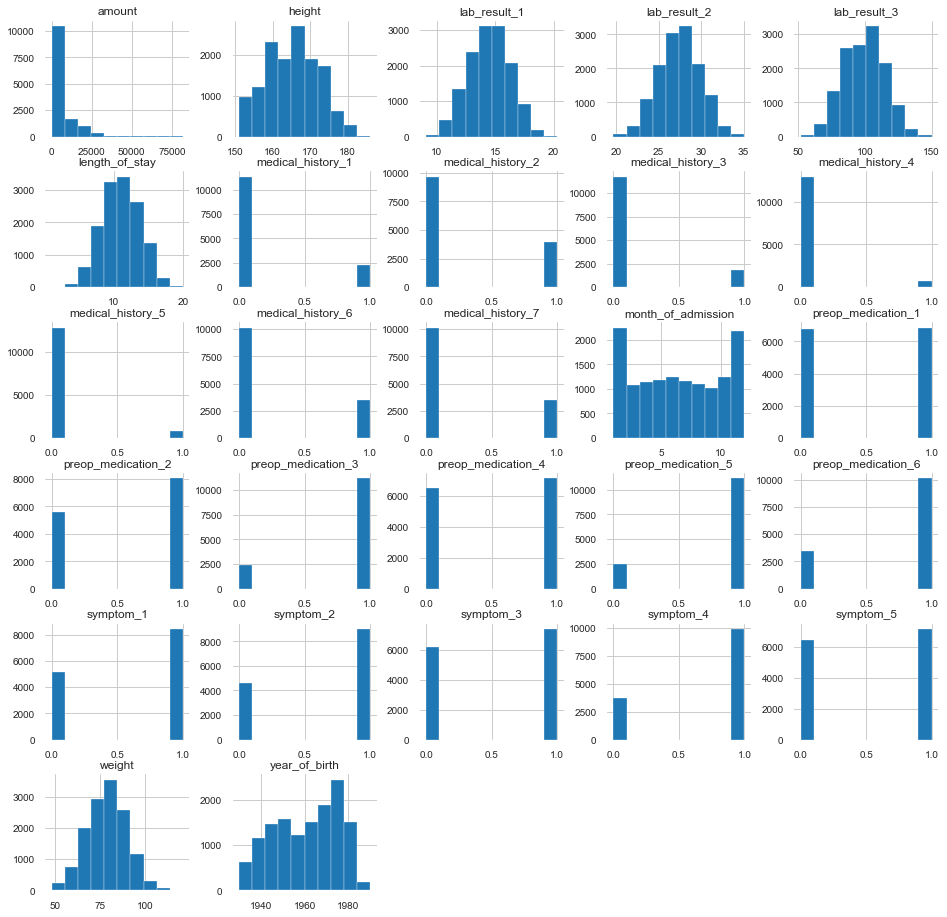

In [24]:
fig = plt.figure(figsize = (16,16))
ax = fig.gca()
treatment_df.hist(ax=ax);

In [25]:
treatment_df.skew()

bill_id              -0.006373
amount                2.275859
medical_history_1     1.765579
medical_history_2     0.925697
medical_history_3     2.121803
medical_history_4     4.033305
medical_history_5     3.773154
medical_history_6     1.126112
medical_history_7     1.127892
preop_medication_1   -0.015296
preop_medication_2   -0.370966
preop_medication_3   -1.673841
preop_medication_4   -0.093052
preop_medication_5   -1.663446
preop_medication_6   -1.119016
symptom_1            -0.493220
symptom_2            -0.686692
symptom_3            -0.179562
symptom_4            -1.016199
symptom_5            -0.107224
lab_result_1         -0.008328
lab_result_2          0.007508
lab_result_3          0.022036
weight                0.008528
height                0.032965
year_of_birth        -0.242439
month_of_admission    0.001604
length_of_stay        0.006284
dtype: float64

In [26]:
nums = treatment_df.select_dtypes(include='number')
cats = treatment_df.select_dtypes(exclude='number')
print(nums.shape)

(13600, 27)


In [27]:
z = np.abs(stats.zscore(nums))
no_nums = nums[(z < 2).all(axis=1)]
print(no_nums.shape)

(9684, 27)


In [28]:
no_nums.skew()

amount                1.699705
medical_history_1     1.742078
medical_history_2     0.953798
medical_history_3     0.000000
medical_history_4     0.000000
medical_history_5     0.000000
medical_history_6     1.117801
medical_history_7     1.139690
preop_medication_1   -0.031401
preop_medication_2   -0.375352
preop_medication_3   -1.629385
preop_medication_4   -0.097197
preop_medication_5   -1.640957
preop_medication_6   -1.143473
symptom_1            -0.476037
symptom_2            -0.652698
symptom_3            -0.166231
symptom_4            -0.977556
symptom_5            -0.067790
lab_result_1          0.012452
lab_result_2         -0.007045
lab_result_3         -0.018136
weight               -0.055960
height                0.005655
year_of_birth        -0.254529
month_of_admission    0.001824
length_of_stay        0.063612
dtype: float64

In [29]:
treatment_df = pd.concat([no_nums, cats], axis=1, join='inner') 

In [30]:
treatment_df.shape

(9684, 35)

### Check for Multicollinearity: Identify and Remove all Predictors with a Corrlelation of >=

In [31]:
corr_mtx = treatment_df.corr().abs()
upper = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.70)]
high_corr

[]

## EDA & Hypothesis Testing

#### Demographics

2. Foreigners are charged more for medical visits.

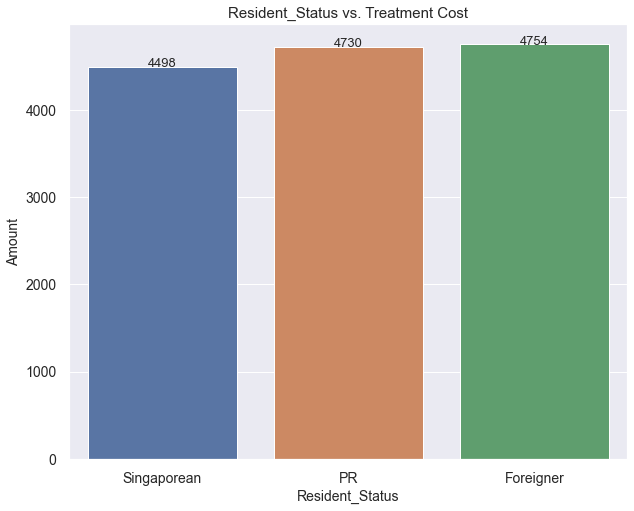

In [119]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(int(p.get_height()))
            ax.text(_x, _y, value, ha="center", size=13) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='resident_status', y='amount', data=treatment_df, ci=None)
ax.set_title('Resident_Status vs. Treatment Cost', fontsize = 15)
ax.set_xlabel('Resident_Status', fontsize=14)
ax.set_ylabel('Amount', fontsize=14)
ax.tick_params(labelsize=14)
show_values_on_bars(ax)

In [33]:
def show_boxplot_values(a,b):
    sns.set(rc={'figure.figsize':(10,8)})

    ax = sns.boxplot(x=a, y=b, data=treatment_df)

    medians = treatment_df.groupby([a])[b].median().astype(int)
    vertical_offset = treatment_df[b].median() * 0.3

    for xtick in ax.get_xticks():
        ax.text(xtick, medians[xtick] + vertical_offset, 
                                        medians[xtick], horizontalalignment='center', size=14, color='black', weight='bold')

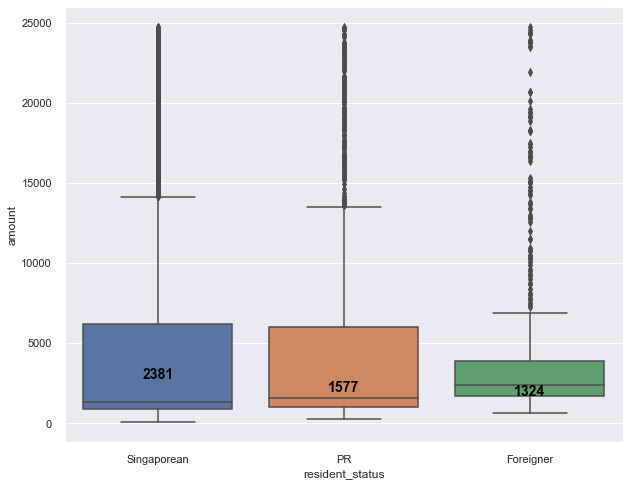

In [34]:
show_boxplot_values(a = 'resident_status', b = 'amount')

3. Demographics vs Cost of Treatment

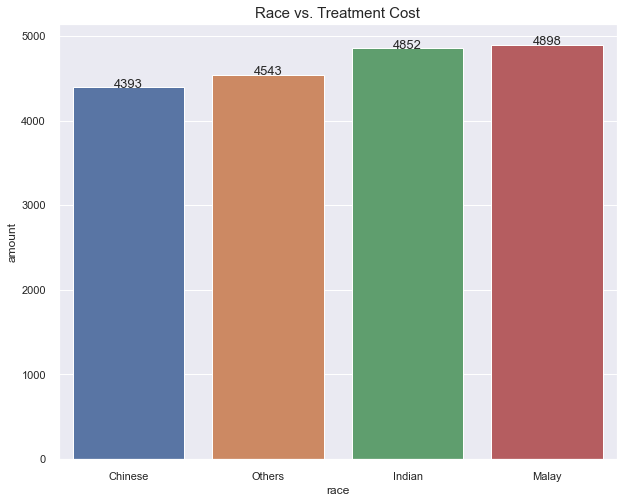

In [35]:
ax = sns.barplot(x='race', y='amount', data=treatment_df, ci=None)
ax.set_title('Race vs. Treatment Cost', fontsize = 15)
ax.set_xlabel('Race', fontsize=14)
ax.set_ylabel('Amount', fontsize=14)
ax.tick_params(labelsize=14)
show_values_on_bars(ax)

4. Age vs. Treatment Cost

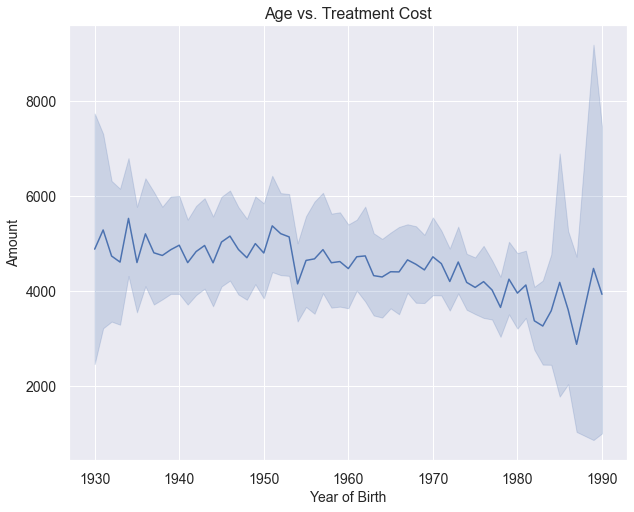

In [36]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.lineplot(data=treatment_df, x='year_of_birth', y='amount')
ax.axes.set_title('Age vs. Treatment Cost', fontsize=16)
ax.set_xlabel('Year of Birth', fontsize=14)
ax.set_ylabel('Amount', fontsize=14)
ax.tick_params(labelsize=14)

5. Weight vs. Amount by Gender

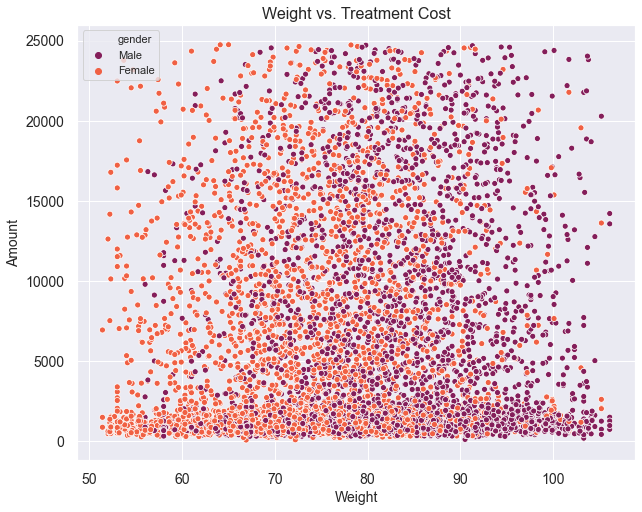

In [37]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.scatterplot(x='weight', y='amount', data=treatment_df, hue='gender', palette='rocket')
ax.axes.set_title('Weight vs. Treatment Cost', fontsize=16)
ax.set_xlabel('Weight', fontsize=14)
ax.set_ylabel('Amount', fontsize=14)
ax.tick_params(labelsize=14)

In [38]:
# Convert month_of_admission to dtype object
treatment_df['month_of_admission'] = treatment_df.month_of_admission.astype('str')

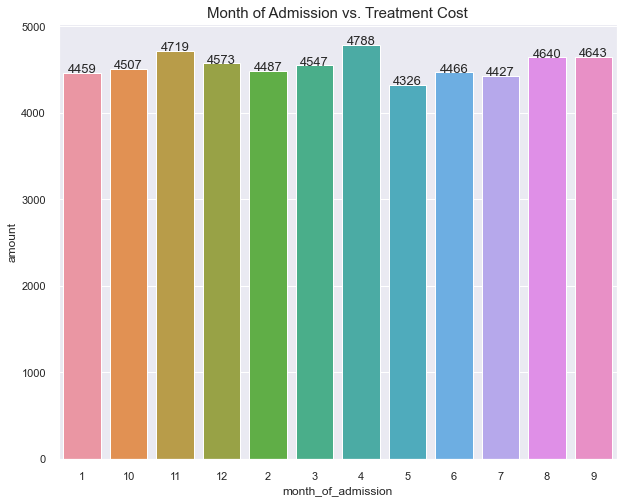

In [39]:
ax = sns.barplot(x='month_of_admission', y='amount', data=treatment_df, ci=None)
ax.set_title('Month of Admission vs. Treatment Cost', fontsize = 15)
show_values_on_bars(ax)

In [40]:
# Convert month_of_admission back to dtype int
treatment_df['month_of_admission'] = treatment_df.month_of_admission.astype('int64')

#### Medical History vs Treatment Cost

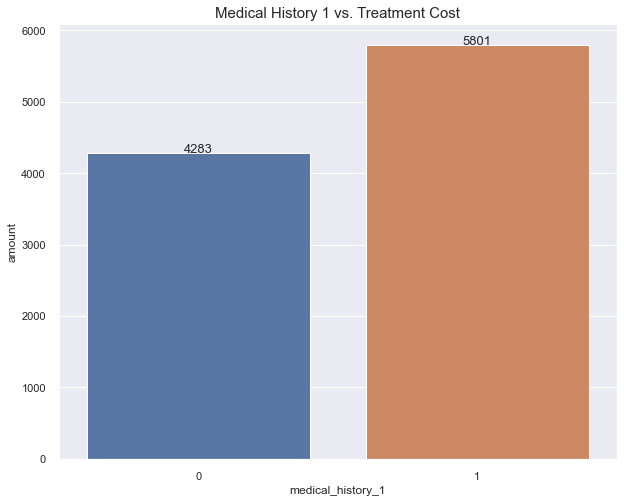

In [41]:
ax = sns.barplot(x='medical_history_1', y='amount', data=treatment_df, ci=None)
ax.set_title('Medical History 1 vs. Treatment Cost', fontsize = 15)
show_values_on_bars(ax)

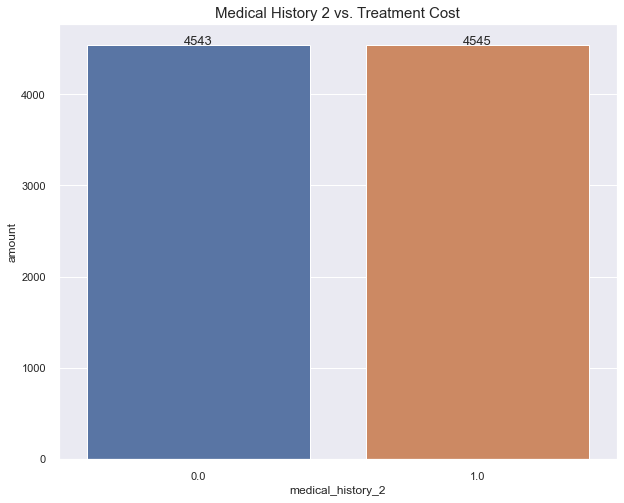

In [42]:
ax = sns.barplot(x='medical_history_2', y='amount', data=treatment_df, ci=None)
ax.set_title('Medical History 2 vs. Treatment Cost', fontsize = 15)
show_values_on_bars(ax)

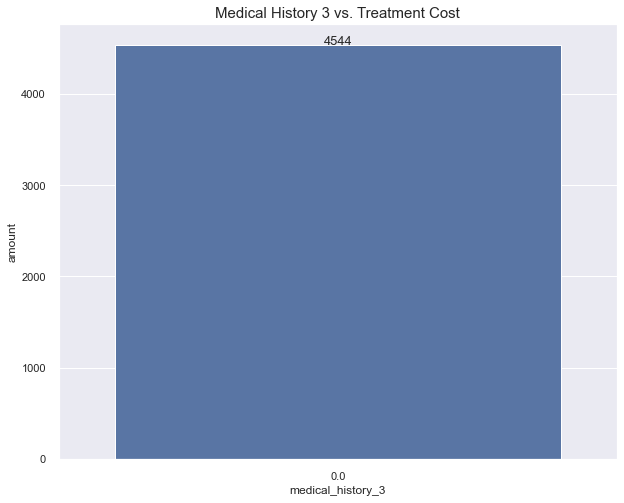

In [43]:
ax = sns.barplot(x='medical_history_3', y='amount', data=treatment_df, ci=None)
ax.set_title('Medical History 3 vs. Treatment Cost', fontsize = 15)
show_values_on_bars(ax)

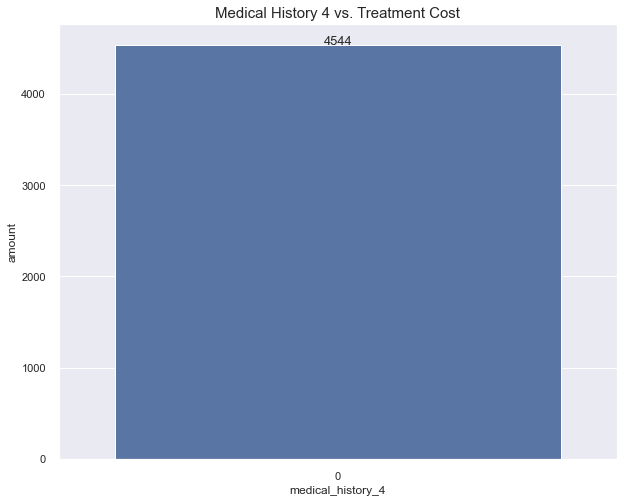

In [44]:
ax = sns.barplot(x='medical_history_4', y='amount', data=treatment_df, ci=None)
ax.set_title('Medical History 4 vs. Treatment Cost', fontsize = 15)
show_values_on_bars(ax)

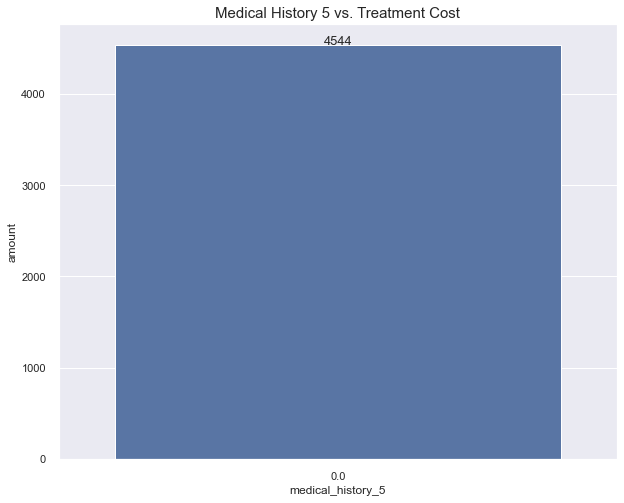

In [45]:
ax = sns.barplot(x='medical_history_5', y='amount', data=treatment_df, ci=None)
ax.set_title('Medical History 5 vs. Treatment Cost', fontsize = 15)
show_values_on_bars(ax)

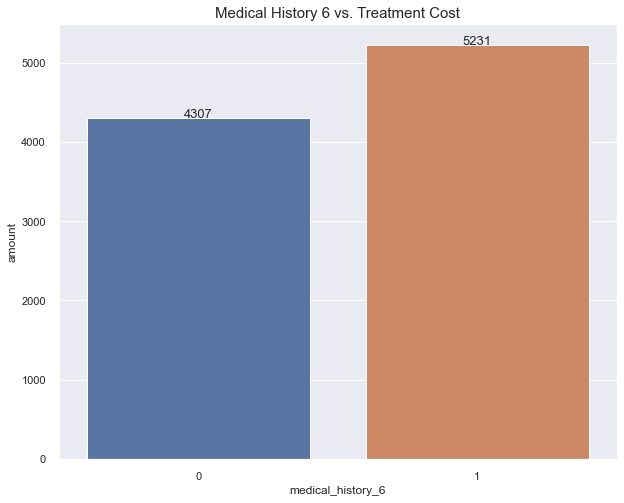

In [46]:
ax = sns.barplot(x='medical_history_6', y='amount', data=treatment_df, ci=None)
ax.set_title('Medical History 6 vs. Treatment Cost', fontsize = 15)
show_values_on_bars(ax)

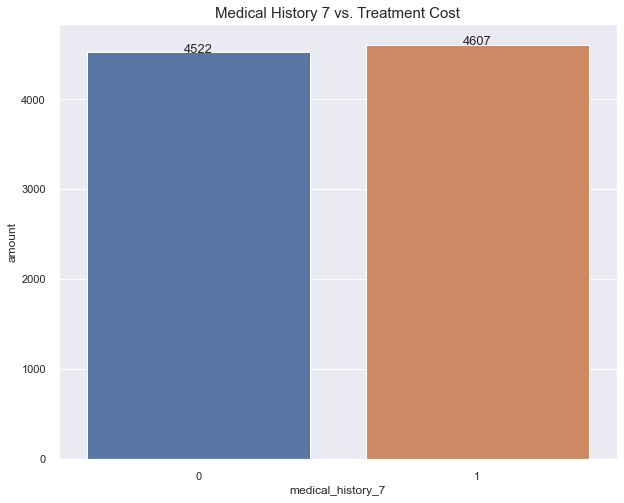

In [47]:
ax = sns.barplot(x='medical_history_7', y='amount', data=treatment_df, ci=None)
ax.set_title('Medical History 7 vs. Treatment Cost', fontsize = 15)
show_values_on_bars(ax)

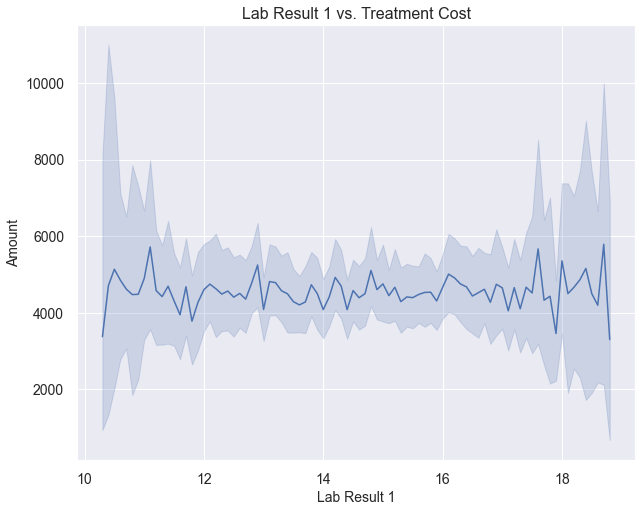

In [48]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.lineplot(data=treatment_df, x='lab_result_1', y='amount')
ax.axes.set_title('Lab Result 1 vs. Treatment Cost', fontsize=16)
ax.set_xlabel('Lab Result 1', fontsize=14)
ax.set_ylabel('Amount', fontsize=14)
ax.tick_params(labelsize=14)

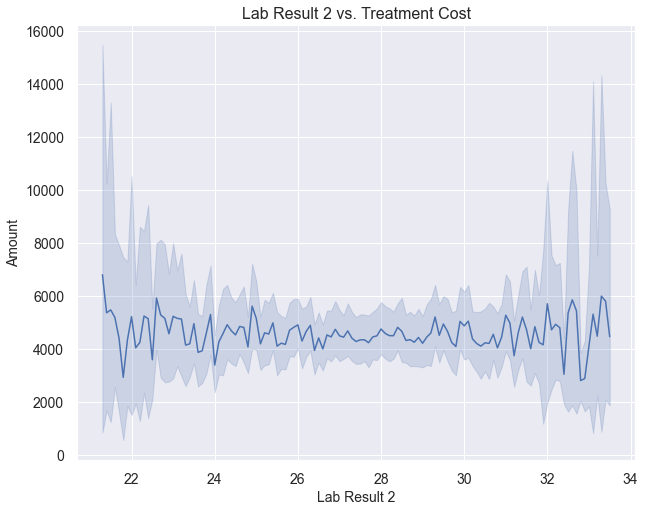

In [49]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.lineplot(data=treatment_df, x='lab_result_2', y='amount')
ax.axes.set_title('Lab Result 2 vs. Treatment Cost', fontsize=16)
ax.set_xlabel('Lab Result 2', fontsize=14)
ax.set_ylabel('Amount', fontsize=14)
ax.tick_params(labelsize=14)

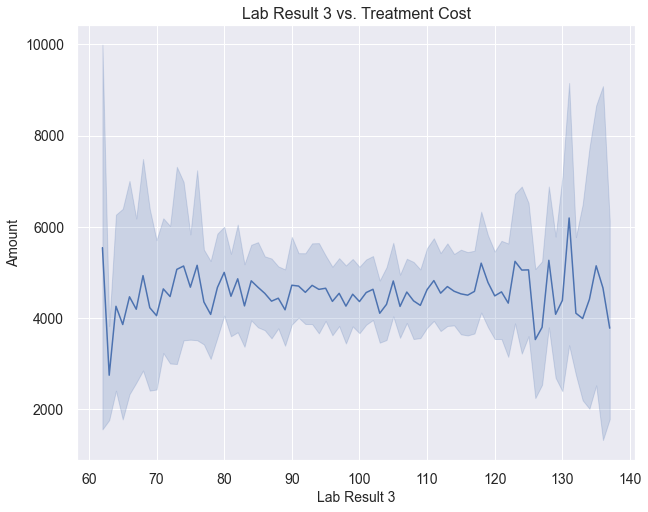

In [50]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.lineplot(data=treatment_df, x='lab_result_3', y='amount')
ax.axes.set_title('Lab Result 3 vs. Treatment Cost', fontsize=16)
ax.set_xlabel('Lab Result 3', fontsize=14)
ax.set_ylabel('Amount', fontsize=14)
ax.tick_params(labelsize=14)

## Modeling

### Feature Selection

In [51]:
# Drop non-useful features and datetime dtypes to create the dataset for modeling
treatment_df = treatment_df.drop(['bill_id', 'patient_id', 'date_of_admission', 'date_of_birth', 
                                   'date_of_discharge'], axis=1)


### Preprocessing: Feature Enginering

In [52]:
base_df = pd.get_dummies(treatment_df, drop_first=True)
base_df.head()

amount  medical_history_1  medical_history_2  medical_history_3  \
1    876.424366                  1                0.0                0.0   
3    836.612493                  1                1.0                0.0   
6   1090.154069                  0                1.0                0.0   
7  14383.364621                  0                0.0                0.0   
8  16733.210549                  1                1.0                0.0   

   medical_history_4  medical_history_5  medical_history_6  medical_history_7  \
1                  0                0.0                  1                  0   
3                  0                0.0                  0                  0   
6                  0                0.0                  0                  0   
7                  0                0.0                  1                  0   
8                  0                0.0                  1                  0   

   preop_medication_1  preop_medication_2  ...  height  year_of_birth  \
1                   0                   1  ...   163.0           1946   
3                   0                   0  ...   151.0           1973   
6                   0                   0  ...   157.0           1982   
7                   0                   1  ...   168.0           1979   
8                   1                   1  ...   177.0           1937   

   month_of_admission  length_of_stay  gender_Male  race_Indian  race_Malay  \
1                  11              13            1            0           0   
3                   2              11            0            0           0   
6                   8              11            0            0           0   
7                   1              12            0            0           0   
8                   8              13            1            0           0   

   race_Others  resident_status_PR  resident_status_Singaporean  
1            0                   0                            1  
3            0                   0                            1  
6            1                   1                            0  
7            0                   0                            1  
8            0                   0                            1  

[5 rows x 33 columns]

In [53]:
y_base = base_df.amount
X_base = base_df.drop('amount', axis=1)

In [54]:
Xb = sm.add_constant(X_base)
model = sm.OLS(y_base, X_base)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 amount   R-squared (uncentered):                   0.386
Model:                            OLS   Adj. R-squared (uncentered):              0.384
Method:                 Least Squares   F-statistic:                              209.4
Date:                Sat, 10 Jul 2021   Prob (F-statistic):                        0.00
Time:                        10:57:27   Log-Likelihood:                         -97790.
No. Observations:                9684   AIC:                                  1.956e+05
Df Residuals:                    9655   BIC:                                  1.958e+05
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
medical_history_1            1542.7788    159.362      9.681      0.000    1230.396    1855.162
medical_history_2             -19.0521    133.186     -0.143      0.886    -280.125     242.021
medical_history_3           -1.486e-12    2.7e-12     -0.550      0.582   -6.78e-12    3.81e-12
medical_history_4            1.477e-11   3.36e-11      0.439      0.661   -5.12e-11    8.07e-11
medical_history_5             6.26e-12   1.35e-11      0.463      0.643   -2.02e-11    3.27e-11
medical_history_6             898.8566    137.994      6.514      0.000     628.360    1169.353
medical_history_7             108.2076    138.575      0.781      0.435    -163.428     379.844
preop_medication_1             89.2328    120.295      0.742      0.458    -146.571     325.037
preop_medication_2            100.8899    122.602      0.823      0.411    -139.436     341.215
preop_medication_3             61.0037    155.288      0.393      0.694    -243.394     365.401
preop_medication_4             34.2221    120.676      0.284      0.777    -202.327     270.772
preop_medication_5              7.4025    155.511      0.048      0.962    -297.431     312.236
preop_medication_6            142.4178    138.619      1.027      0.304    -129.304     414.140
symptom_1                     254.3849    123.514      2.060      0.039      12.272     496.497
symptom_2                     378.7429    126.499      2.994      0.003     130.777     626.708
symptom_3                     461.3921    120.826      3.819      0.000     224.547     698.237
symptom_4                     376.6325    133.710      2.817      0.005     114.533     638.732
symptom_5                    1202.1910    120.450      9.981      0.000     966.084    1438.298
lab_result_1                   -5.8739     34.819     -0.169      0.866     -74.126      62.379
lab_result_2                   15.3857     25.312      0.608      0.543     -34.231      65.002
lab_result_3                    3.2115      4.071      0.789      0.430      -4.768      11.191
weight                         18.2236      6.161      2.958      0.003       6.146      30.301
height                         15.6078     11.956      1.305      0.192      -7.829      39.044
year_of_birth                  -1.3340      1.130     -1.181      0.238      -3.548       0.880
month_of_admission              8.8784     17.600      0.504      0.614     -25.622      43.379
length_of_stay                 15.2763     21.404      0.714      0.475     -26.680      57.232
gender_Male                  -130.7621    176.535     -0.741      0.459    -476.807     215.283
race_Indian                   440.6929    203.564      2.165      0.030      41.664     839.721
race_Mal

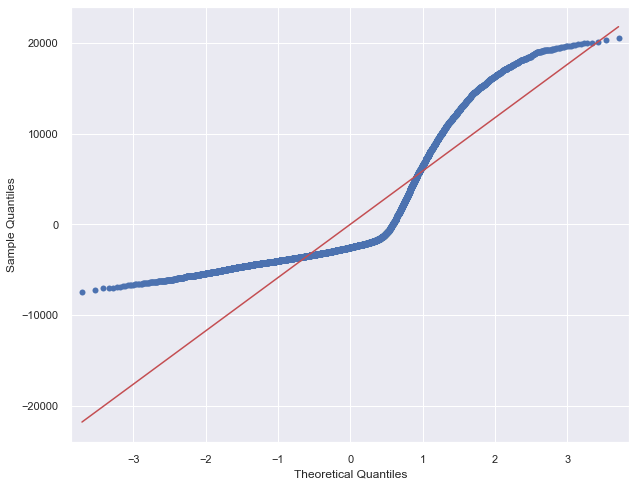

In [106]:
# Check Q-Q Plot
res = results.resid
fig = sm.qqplot(res, line='s')
plt.show()

### Create Final Dataset

In [57]:
# Drop features with P value > 0.05
feats_to_keep = ['medical_history_1', 'medical_history_6', 'symptom_1', 'symptom_2', 'symptom_3',
                'symptom_4', 'symptom_5', 'race_Indian', 'race_Malay', 'weight', 'amount']


model_dataset = base_df[feats_to_keep]
model_dataset.head()

medical_history_1  medical_history_6  symptom_1  symptom_2  symptom_3  \
1                  1                  1          0          0          0   
3                  1                  0          1          0          0   
6                  0                  0          1          0          1   
7                  0                  1          1          1          0   
8                  1                  1          1          1          1   

   symptom_4  symptom_5  race_Indian  race_Malay  weight        amount  
1          1          1            0           0    89.9    876.424366  
3          1          1            0           0    80.2    836.612493  
6          1          0            0           0    80.0   1090.154069  
7          1          1            0           0    76.8  14383.364621  
8          1          0            0           0    95.1  16733.210549

In [58]:
# Copy dataset
model_dataset_copy = model_dataset.copy()

### Build Regression Pipleline

In [59]:
# Partition
y = model_dataset.amount
X = model_dataset.drop(['amount'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Define continuous features 
continuous = list(X_train.select_dtypes(include = ['number']))

# Define object features
objects = list(X_train.select_dtypes(exclude = ['number']))

In [61]:
# Define Object Pipeline
obj_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant')), 
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define Continuous Pipeline
contin_pipe_maxab = Pipeline([('imputer', SimpleImputer(strategy='median')), 
                        ('scaler', MaxAbsScaler())])

# Combine Object & Continuous Feature Pipeline
preprocess_maxab = ColumnTransformer([('obj', obj_pipe, objects), 
                                ('cont', contin_pipe_maxab, continuous)])

### Baseline Model: Linear Regression

In [62]:
# Fit pipline with transformers and estimator to training data
pipe1 = Pipeline([('preprocessor', preprocess_maxab), ('model', LinearRegression())])
model1 = pipe1.fit(X_train, y_train)

In [63]:
# Predict training data
y_train_pred1 = pipe1.predict(X_train)

# Predict test and test
y_test_pred1 = pipe1.predict(X_test)

In [64]:
# Print R^2
print('Train R^2: ', r2_score(y_train, y_train_pred1))
print('Test R^2: ', r2_score(y_test, y_test_pred1))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred1)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred1)))

Train R^2:  0.03118027178033389
Test R^2:  0.021733043060014667
Train Root Mean Square Error 5874.145259660038
Test Root Mean Square Error 5914.966119622965


### Linear Regression. Scaler: Yeo-Johnson

In [ ]:
# Define Continuous Pipeline
contin_pipe_yeo = Pipeline([('imputer', SimpleImputer(strategy='median')), 
                        ('power', PowerTransformer(method='yeo-johnson', standardize=True))])

# Combine Object & Continuous Feature Pipeline
preprocess_yeo = ColumnTransformer([('obj', obj_pipe, objects), 
                                ('cont', contin_pipe_yeo, continuous)])

In [112]:
pipe1a = Pipeline([('preprocessor', preprocess_yeo), ('model', LinearRegression())])
pipe1a.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('obj',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  []),
                                                 ('cont',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxSc

In [113]:
model1a = pipe1a.fit(X_train, y_train)
                
# Predict training data
y_train_pred1a = pipe1a.predict(X_train)

# Predict test and test
y_test_pred1a = pipe1a.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_pred1a))
print('Test R^2: ', r2_score(y_test, y_test_pred1a))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred1a)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred1a)))

Train R^2:  0.03118027178033389
Test R^2:  0.02173304306001478
Train Root Mean Square Error 5874.145259660038
Test Root Mean Square Error 5914.966119622965


### Linear Regression: Standard Scaler

In [69]:
# Define Continuous Pipeline
std_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), 
                        ('scaler', StandardScaler())])

# Combine Object & Continuous Feature Pipeline
preprocess_std = ColumnTransformer([('obj', obj_pipe, objects), 
                                ('cont', std_pipe, continuous)])

In [70]:
pipe1b = Pipeline([('preprocessor', preprocess_std), ('model', LinearRegression())])
pipe1b.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('obj',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  []),
                                                 ('cont',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   Standard

In [71]:
model1b = pipe1b.fit(X_train, y_train)
                
# Predict training data
y_train_pred1b = pipe1b.predict(X_train)

# Predict test and test
y_test_pred1b = pipe1b.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_pred1b))
print('Test R^2: ', r2_score(y_test, y_test_pred1b))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred1b)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred1b)))

Train R^2:  0.03118027178033389
Test R^2:  0.021733043060014556
Train Root Mean Square Error 5874.145259660038
Test Root Mean Square Error 5914.966119622965


In [ ]:
stop here, move forward with the highest performing transformer

### Try Polynomial Regression: Degree = 2

In [72]:
# Max Absolute Scaler
poly_feats2 = PolynomialFeatures(degree=2, include_bias=False)
pipe2 = Pipeline([('preprocessor', preprocess),
                 ('poly', poly_feats2), ('model', LinearRegression())])


In [73]:
model2 = pipe2.fit(X_train, y_train)
                
# Predict training data
y_train_pred2 = pipe2.predict(X_train)

# Predict test and test
y_test_pred2 = pipe2.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_pred2))
print('Test R^2: ', r2_score(y_test, y_test_pred2))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred2)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred2)))

Train R^2:  0.043692319598088614
Test R^2:  0.02961798808962357
Train Root Mean Square Error 5836.090485656601
Test Root Mean Square Error 5891.080235336099


### Poly Regression: Degree 2, Create Interaction Terms

In [74]:
poly_feats2a = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
pipe2a = Pipeline([('preprocessor', preprocess),
                 ('interact_poly', poly_feats2a), ('model', LinearRegression())])



In [75]:
model2a = pipe2a.fit(X_train, y_train)
                
# Predict training data
y_train_pred2a = pipe2a.predict(X_train)

# Predict test and test
y_test_pred2a = pipe2a.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_pred2a))
print('Test R^2: ', r2_score(y_test, y_test_pred2a))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred2a)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred2a)))

Train R^2:  0.043966407857431555
Test R^2:  0.030148142263179634
Train Root Mean Square Error 5835.254081982453
Test Root Mean Square Error 5889.470762248231


### Poly Regression: Degree = 4

In [90]:
poly_feats3 = PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)
pipe3 = Pipeline([('preprocessor', preprocess),
                  ('inter_poly', poly_feats3), ('model', LinearRegression())
                ])

In [80]:
model3 = pipe3.fit(X_train, y_train)
                
# Predict training data
y_train_pred3 = pipe3.predict(X_train)

# Predict test and test
y_test_pred3 = pipe3.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_pred3))
print('Test R^2: ', r2_score(y_test, y_test_pred3))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred3)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred3)))

Train R^2:  0.059507441347975365
Test R^2:  -0.029705335982447734
Train Root Mean Square Error 5787.631567657863
Test Root Mean Square Error 6068.4817574515755


#### Try Regularization Methods

In [95]:
# Ridge Regression
poly_featsreg = PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)
pipe_reg = Pipeline([('preprocessor', preprocess),
                     ('inter_poly', poly_featsreg), 
                     ('model', Ridge(alpha=100, fit_intercept=True))
                ])

In [96]:
model_reg = pipe_reg.fit(X_train, y_train)
                
# Predict training data
y_train_predr = pipe_reg.predict(X_train)

# Predict test and test
y_test_predr = pipe_reg.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_predr))
print('Test R^2: ', r2_score(y_test, y_test_predr))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_predr)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_predr)))

Train R^2:  0.048647764104844504
Test R^2:  0.025094167345724894
Train Root Mean Square Error 5820.949968722786
Test Root Mean Square Error 5904.7960723598


In [101]:
# Lasso
poly_feats_lasso = PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)
pipe_lasso = Pipeline([('preprocessor', preprocess),
                     ('inter_poly', poly_feats_lasso), 
                     ('model', LassoCV(cv=5, random_state=0))
                ])



In [102]:
model_lasso = pipe_lasso.fit(X_train, y_train)
                
# Predict training data
y_train_predl = pipe_lasso.predict(X_train)

# Predict test and test
y_test_predl = pipe_reg.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_predl))
print('Test R^2: ', r2_score(y_test, y_test_predl))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_predl)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_predl)))

Train R^2:  0.042284312841885385
Test R^2:  0.025094167345724894
Train Root Mean Square Error 5840.385250085135
Test Root Mean Square Error 5904.7960723598


### Polynomial Regression: Degree = 8

In [97]:
# Ridge
poly_feats4 = PolynomialFeatures(degree=8, interaction_only=True, include_bias=False)
pipe4 = Pipeline([('preprocessor', preprocess),
                  ('inter_poly', poly_feats4), 
                  ('model', Ridge(alpha=100, fit_intercept=True))])

In [98]:
model4 = pipe4.fit(X_train, y_train)
                
# Predict training data
y_train_pred4 = pipe4.predict(X_train)

# Predict test and test
y_test_pred4 = pipe4.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_pred4))
print('Test R^2: ', r2_score(y_test, y_test_pred4))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred4)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred4)))

Train R^2:  0.050140882451386815
Test R^2:  0.021470304896123227
Train Root Mean Square Error 5816.380273213448
Test Root Mean Square Error 5915.760372660666


In [103]:
# Lasso
poly_feats5 = PolynomialFeatures(degree=8, interaction_only=True, include_bias=False)
pipe5 = Pipeline([('preprocessor', preprocess),
                  ('inter_poly', poly_feats5), 
                  ('model', LassoCV(cv=5, random_state=0))])

In [104]:
model5 = pipe5.fit(X_train, y_train)
                
# Predict training data
y_train_pred5 = pipe5.predict(X_train)

# Predict test and test
y_test_pred5 = pipe5.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_pred5))
print('Test R^2: ', r2_score(y_test, y_test_pred5))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred5)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred5)))

Train R^2:  0.042387135215893434
Test R^2:  0.033489645496230125
Train Root Mean Square Error 5840.071723636844
Test Root Mean Square Error 5879.316290885534


In [116]:
poly_feats6 = PolynomialFeatures(degree=8, interaction_only=True, include_bias=False)
pipe6 = Pipeline([('preprocessor', preprocess),
                  ('inter_poly', poly_feats6), 
                  ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
                  ('model', LassoCV(cv=5, random_state=0))
                ])



In [117]:
model6 = pipe6.fit(X_train, y_train)
                
# Predict training data
y_train_pred6 = pipe6.predict(X_train)

# Predict test and test
y_test_pred6 = pipe6.predict(X_test)
                 
print('Train R^2: ', r2_score(y_train, y_train_pred6))
print('Test R^2: ', r2_score(y_test, y_test_pred6))

# Print RMSE
print('Train Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred6)))
print('Test Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred6)))

Train R^2:  0.04111406671137485
Test R^2:  0.027593849836385242
Train Root Mean Square Error 5843.952384755506
Test Root Mean Square Error 5897.221192647402


In [ ]:

poly_feats7 = PolynomialFeatures(degree=8, interaction_only=True, include_bias=False)
pipe7 = Pipeline([('preprocessor', preprocess),
                  ('inter_poly', poly_feats6), 
                  ('scaler', MinMaxScaler()),
                  ('model', LassoCV(cv=5, random_state=0))
                ])

